# 洗錢相關新聞探索性資料分析(EDA)
## Issue:
金融業法律遵循需要定期提報洗錢高風險名單給金管會，  
而目前實務方式為人力上網利用關鍵字搜尋新聞，人眼判斷後，   
再蒐集可能有涉及洗錢的人名及相關新聞，  
但過程極度耗時且浪費人力資源，故思考是否有解決方案  
## Aimstatement:
想利用底下程式，探索洗錢新聞的資料特性，知道如何自動化相關流程  

In [1]:
# -*- coding: UTF-8 -*-
import requests
from bs4 import BeautifulSoup
from lxml import etree
import re
import time
import pandas as pd
import os
import json
import jieba
from google import google
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

## 爬取中國時報的新聞

In [2]:
def get_html(url):
    #模擬訪問頁面的函數
    try:
        user_agent = 'Mozilla/5.0'
        resp = requests.get(url, headers={'User-Agent': user_agent}, timeout = 30) #回傳為一個request.Response的物件
        resp.endcoding = 'utf8'
        #response = resp.content.decode()
        #c = resp.status_code
        return resp.text
    except:
        return 'ERROR'

In [3]:
def get_china_times_news(keyword):
    #函數用來爬取中國時報特定關鍵字下的新聞內容，函數內可以再設定要爬取的頁數（或之後用時間來選）
    page_num = 10
    url_list = []
    #取得指定搜尋頁數裡的新聞url，並存成url_list
    for i in range(page_num):
        html = get_html('https://www.chinatimes.com/search/'+ keyword +'?page='+str(i+1)+'&chdtv')
        tree = etree.HTML(html)
        for j in range(13):
            url = tree.xpath('/html/body/div[2]/div/div[2]/div/section/div/ul/li['+ str(j+1) +']/div/div/div/h3/a/@href')
            url_list.append("".join(url))
    while '' in url_list: #廣告是空的，每一頁13個url中有3個是廣告，但抓下來都是空的，就去掉
        url_list.remove('')
    for i in range(len(url_list)):
        url_list[i] += '?chdtv'
    print(url_list)
     
    #開始訪問每個新聞連結並取得內容，最後寫進檔案
    w = open(keyword + "_all_china_times_news.txt", 'w')
    for i in url_list:
        text = get_html(i)
        html = etree.HTML(text)
        news_header = html.xpath('//*[@id="page-top"]/div/div[2]/div/div/article/div/header/h1/text()')
        news_content = html.xpath('//*[@id="page-top"]/div/div[2]/div/div/article/div/div[1]/div[2]/div[2]/div[2]//text()')
        news_date = html.xpath('//*[@id="page-top"]/div/div[2]/div/div/article/div/header/div/div[1]/div/div/time/span[2]/text()')
        news_content_str = str()
        news_content_str += "".join(news_header)
        news_content_str += "\n"
        news_content_str += news_date[0]
        news_content_str += "\n"
        for j in news_content:
            if j[0] != "\n":
                news_content_str += j
        w.write(news_content_str)
        #print(news_content_str)
        w.write('\n')
        #time.sleep(1)應該不是一次太多request的問題
    
    print(news_content_str)
    w.close()
    return 'yeah'


## 設定洗錢相關的關鍵字、爬蟲

In [4]:
keyword_list = ["賄賂","貪污", "洗錢", "詐欺", "境外轉帳", "詐騙"]
# for i in keyword_list:
#     crawl = get_china_times_news(i)
#crawl1 = get_china_times_news("洗錢")


## 讀入爬蟲存下來的檔案、整理資料

In [5]:
#先以洗錢為資料探索的目標
with open("洗錢_all_china_times_news.txt","r") as r1:
    all_article = r1.read()
print(all_article)
#把文字變成list
all_article = all_article.split("\n")
for i in range(4):
    del all_article[-1]
#轉array
num = len(all_article)
data = np.array(all_article).reshape((num//3),3)


落實KYC 有效降低金融犯罪
2019/05/30
KPMG安侯建業聯合會計師事務所於今（30）日舉辦「國際金融犯罪防制研討會」。KPMG安侯建業風險顧問暨鑑識會計團隊執行副總朱成光指出，當前金融機構持續優化洗錢防制措施之具體作為建議可朝下列三大方向推動，包括思考執行AML科技系統驗證與交易資料完整性驗證、整合反貪腐及反賄賂管理機制於金融機構風險評估報告書、防範資助大規模毀滅性武器擴散等，落實KYC客戶審查作為。朱成光進一步說明，洗錢防制管控措施採行科技系統輔助上，金融機構需了解科技系統運作上是否發揮建置時設定的功能與預期風險管理目標，而科技系統是足以影響洗錢風險管理關鍵控管機制成敗之重要因素。因此，金融機構應規畫就現有AML科技系統進行驗證以達到風險管理之目的。此外，隨著我國行政院會剛通過「揭弊者保護法草案」，在整體洗錢防制作業優化作為上，金融機構可思考將貪腐風險與洗錢、資恐暨武擴風險以主動積極的角度涵蓋於機構風險評估報告書中，讓洗錢防制機制更即時地與國內外法令遵循趨勢接軌。(工商 )#風險#金融#洗錢#機構#金融機構
大陸反洗錢師成奇貨
2019/05/26
成為一名反洗錢師的條件隨著金融科技興起及官方對金融安全重視的提升，大陸的反洗錢人才變得異常搶手，民間業界與機構常見搶人大戰。據21世紀經濟報導稱，中國互聯網金融協會與公認反洗錢師協會（ACAMS）近期簽署互聯網金融反洗錢合作諒解備忘錄，雙方將在互金領域就反洗錢資源分享、人員培訓、資格認證等方面深入合作。但這一合作背後，突顯出大陸政府在向互聯網金融機構要求強化反洗錢舉措時，相關專業人才稀缺的情況。對此，公認反洗錢師協會執行董事、亞太區執行長鄧芳慧表示，目前大陸境內公認反洗錢師約有1萬名，但整個行業的需求卻約在22萬～25萬名，這顯示市場對反洗錢師的迫切需求。房仲、會計師 需才孔亟鄧芳慧指出，不止是金融機構、互聯網金融機構，未來反洗錢要求還將推向房地產開發及仲介機構、貴金屬交易所、會計師事務所、律師事務所等，這讓原本緊俏的反洗錢人才愈顯不足。以上海為例，其金融領域「十三五」緊缺人才開發目錄中，就已經把合規與反洗錢人才列為極度緊缺等級。目前在大陸的招聘網站上，明確提出反洗錢工作需求的知名大企業，包括平安銀行、中國郵儲銀行、寧波銀行、百信銀行等銀行機構，還有中國出口信用保險公司、太平人壽等保險公司。另外還有券商業者

In [6]:
datadf = pd.DataFrame(data, columns = ['header','date','content'])
datadf

,header,date,content
0,落實KYC 有效降低金融犯罪,2019/05/30,KPMG安侯建業聯合會計師事務所於今（30）日舉辦「國際金融犯罪防制研討會」。KPMG安侯建...
1,大陸反洗錢師成奇貨,2019/05/26,成為一名反洗錢師的條件隨著金融科技興起及官方對金融安全重視的提升，大陸的反洗錢人才變得異常搶...
2,陸反洗錢師奇缺 掀搶人戰,2019/05/21,
3,華裔女扮華為員工 在英國開妓院,2019/05/17,英國倫敦的肯特郡日前偵破一起案件，稱有一個犯罪集團假扮成華為公司的員工，並以其名義租房開設妓...
4,洗錢推高溫哥華房價,2019/05/11,加拿大英屬哥倫比亞省政府資料指出，去年有逾70億加元透過當地的經濟體系洗錢，這些被漂白的不法...
5,金管會：進沙盒有碰錢 就要防洗錢,2019/05/10,進沙盒實驗只要有摸到錢，就得防洗錢。金管會9日公布，金融監理沙盒的防制洗錢及打擊資恐辦法確定...
6,加拿大：非法資金推高房價,2019/05/10,加拿大西部英屬哥倫比亞省政府資料指出，2018年有逾70億加元透過當地的經濟體系洗錢，這些被...
7,無畏新創反彈 金管會：進沙盒也要防洗錢,2019/05/09,進沙盒實驗只要有摸到錢，就得防洗錢。金管會9日公布，金融監理沙盒的防制洗錢及打擊資恐辦法確定...
8,出國旅遊、船員出海帶現鈔 有金額限制,2019/05/09,關務署9日表示，為配合洗錢防制法、洗錢防制物品出入境申報等規定，不論是船員、一般旅客出入國境...
9,痛擊地下匯兌 斷絕洗錢管道,2019/05/05,


## 正面新聞跟負面新聞整個文本使用的字詞特性長怎樣呢？
分析前猜測洗錢的相關新聞中，正面新聞及負面新聞會有特定的用詞，利用底下的方式驗證

In [7]:
#先自定義跟洗錢相關的切詞字典
jieba.load_userdict("/Users/rikeion/Desktop/CS+XDataScience_HW1/user_dict.txt")
word_counter = []
word_count_dict = []
#處理廢字、切詞、算詞頻
no_use = ["，", "。","、","「","」","(",")","？","—","#","（","）","的","有","在","與","及","和","是","也","對","了","之","於"," "]
for i in datadf.iloc[:,2]:
    cut = jieba.cut(i, cut_all = False)
    clean_cut = []
    for j in cut:
        if j[0] not in no_use:
            clean_cut.append(j)
    word_counter.append(Counter(clean_cut).most_common(20))
for i in range(len(word_counter)):
    dic = dict()
    for j in word_counter[i]:
        dic[j[0]] = j[1]
    word_count_dict.append(dic)
#print(word_count_dict)


Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/4s/mykg15b9135fc0jvn3h80fl00000gn/T/jieba.cache
Loading model cost 1.242 seconds.
Prefix dict has been built succesfully.


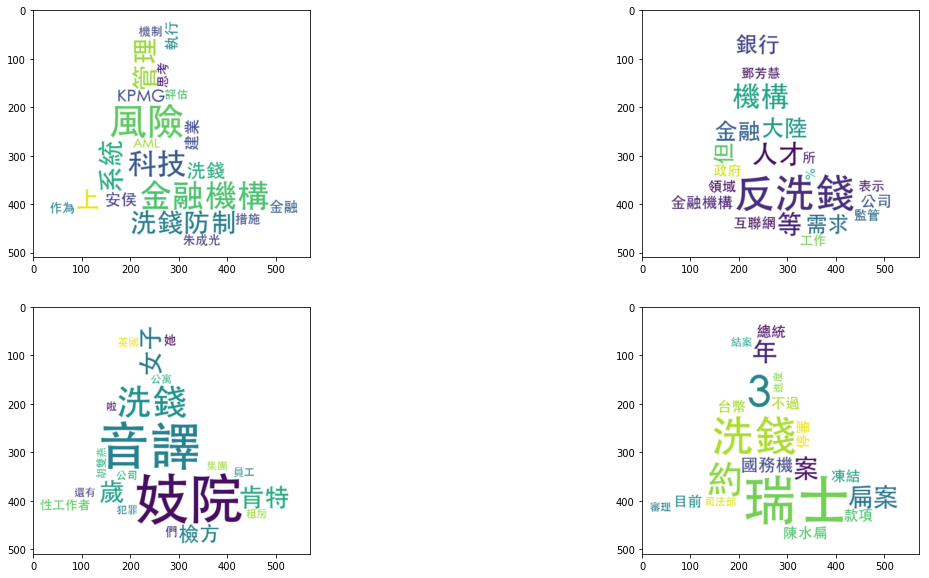

In [8]:
#微軟正黑體
font_path="/System/Library/Fonts/STHeiti Medium.ttc"
#想要文字雲出現的圖示
mask = np.array(Image.open(r"錢錢.jpg"))
location = 0
plt.figure(figsize=(20,10), facecolor='w')
for i in [0,1,3,10]:
    location += 1
    try:
        my_wordcloud = WordCloud(background_color="white",mask=mask,font_path=font_path,collocations=False, width=2400, height=2400, margin=2)  
        my_wordcloud.generate_from_frequencies(word_count_dict[i])

        #產生圖片
        plt.subplot(2,2,location)
        plt.imshow(my_wordcloud,interpolation='bilinear')
        plt.title[datadf['header'][i]]
        plt.tight_layout(pad=0)
        #顯示用
        plt.show()
    except:
        "No content"


從上面的圖中可以看出，確實反洗錢相關新聞與洗錢的新聞中，常用字有著蠻大的差異，反洗錢相關新聞會提到金融監理、會計師事務所（例如KPMG），以及一些"評估、執行、監管、政府、措施"等等較為官方且政府用字的描述，而反觀負面的新聞中，會有較多犯罪相關的字，並且提到檢方、洗錢、凍結、審判等。故從上面的分析中可以看出，若歸類洗錢相關犯罪用字（包含動詞等），有機會能自動化判斷是否為洗錢新聞。

## 用TF-IDF來看看文字特徵及哪些字是重要的

In [9]:
#TFIDF
#產出一個稀疏矩陣
corpus = []
for i in datadf.iloc[:,2]:
    cut = jieba.cut(i, cut_all = False)
    clean_cut = []
    for j in cut:
        if j[0] not in no_use:
            clean_cut.append(j) 
    corpus.append(" ".join(clean_cut))

vec = TfidfVectorizer()
tfidf_data = vec.fit_transform(corpus)
matrix = pd.DataFrame(tfidf_data.toarray(), columns = vec.get_feature_names())

matrix.T
#显示所有行、列
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)


,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.039366
016,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.082093,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
02,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
033,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
039,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
08,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
10,0.0,0.019801,0.0,0.0,0.0,0.000000,0.0,0.000000,0.049402,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.083733,0.0,0.0,0.000000
100,0.0,0.000000,0.0,0.0,0.0,0.036437,0.0,0.035810,0.000000,0.0,...,0.110763,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
106,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


### 底下用隨機的三個文本TFIDF做分析

In [11]:
#對第一個文本（正面講反洗錢的文本）選出TFIDF值大於0.1的詞
matrix = matrix.T
mask1 = matrix.iloc[:,7] >= 0.1
matrix[mask1]

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
人員,0.000000,0.047736,0.0,0.0,0.000000,0.115318,0.000000,0.113332,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028016
創業者,0.000000,0.000000,0.0,0.0,0.000000,0.143667,0.000000,0.141193,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037337,0.000000
另外,0.000000,0.021079,0.0,0.0,0.036213,0.101846,0.035180,0.100092,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.032218,0.000000,0.000000,0.026469,0.024743
只要,0.000000,0.000000,0.0,0.0,0.000000,0.237490,0.000000,0.233401,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028849
實驗,0.000000,0.000000,0.0,0.0,0.000000,0.219283,0.000000,0.215506,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.376126,0.000000
專責,0.000000,0.000000,0.0,0.0,0.000000,0.151691,0.000000,0.149078,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
成本,0.000000,0.026238,0.0,0.0,0.000000,0.169024,0.000000,0.166114,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061596
排除,0.000000,0.000000,0.0,0.0,0.000000,0.143667,0.000000,0.141193,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
收受,0.000000,0.000000,0.0,0.0,0.000000,0.175426,0.000000,0.172405,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068386,0.000000
林志吉,0.000000,0.000000,0.0,0.0,0.000000,0.216046,0.000000,0.212325,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


從上面7號文本利用TFIDF取出的特徵可以看到，確實如EDA的發現，不是報導洗錢犯罪的文章中，較為正面、反洗錢相關的特徵詞彙較多，之後如果做句法分析的時候可以把相關特徵字列入正面詞彙的字典。

In [12]:
#對第十個文本（負面講控訴洗錢審理的文本）選出TFIDF值大於0.1的詞
mask1 = matrix.iloc[:,10] >= 0.1
matrix[mask1]

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
停審,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
凍結,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
司法部,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
國務機,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
審理,0.0,0.0,0.0,0.052069,0.0,0.042256,0.0,0.041528,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
扁案,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
檢方,0.0,0.0,0.0,0.150988,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
款項,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
瑞士,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
結案,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [13]:
#對第十個文本（負面講控訴洗錢審理的文本）選出TFIDF值大於0.1的詞
mask1 = matrix.iloc[:,21] >= 0.1
matrix[mask1]

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
交保,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
回扣,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
廉政,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
收受,0.0,0.000000,0.0,0.000000,0.0,0.175426,0.0,0.172405,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.068386,0.000000
施明德,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
李姓,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
業者,0.0,0.023868,0.0,0.000000,0.0,0.076879,0.0,0.075555,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.119879,0.084049
檢廉,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
涉嫌,0.0,0.000000,0.0,0.046081,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
移民,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000



從上面兩個抽取負面文本的特徵可以看出，有關於審判、審理、交保、回扣、涉嫌等等的特徵是負面文本常出現的，符合上面EDA的兩個文字雲圖片。

## 小結
目前經由探索性的資料分析發現，正面（沒有洗錢）及負面（有洗錢）的文本跟句子有明顯固定使用的詞彙特徵，故下一步若要自動化對於洗錢新聞的判斷，可以使用句法分析搭配洗錢議題的正面負面詞彙字典，或可以考慮使用LSTM來訓練辨識犯罪的NER model。